# Water heating

An insulated, rigid tank contains 4 kg of water at 100 kPa, where initially 0.25 of the mass is liquid. An electric heater turns on and operates until all of the liquid has vaporized. (Neglect the heat capacity of the tank and heater.)

![Water heater](../../images/water-heater.png)

**Problem:** 
- Determine the final temperature and pressure of the water.
- Determine the electrical work required by this process.
- Determine the total change in entropy associated with this process.
- Plot the state points for the water on a temperature-specific entropy diagram.

First, load the necessary modules and specify the known/initial conditions.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cantera as ct

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'png')
plt.rcParams['figure.dpi']= 300
plt.rcParams['savefig.dpi'] = 300

from pint import UnitRegistry
ureg = UnitRegistry()
Q_ = ureg.Quantity

In [2]:
mass = Q_(4, 'kg')
pressure_initial = Q_(100, 'kPa')
quality_initial = 0.25

quality_final = 1.0

# specify the initial state using pressure and quality
state_initial = ct.Water()
state_initial.PQ = pressure_initial.to('Pa').magnitude, quality_initial
state_initial()


  water:

       temperature   372.81 K
          pressure   1e+05 Pa
           density   2.3567 kg/m^3
  mean mol. weight   18.016 kg/kmol
    vapor fraction   0.25
   phase of matter   liquid-gas-mix

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy       -1.4989e+07       -2.7004e+08  J
   internal energy       -1.5031e+07        -2.708e+08  J
           entropy            6337.1        1.1417e+05  J/K
    Gibbs function       -1.7351e+07        -3.126e+08  J
 heat capacity c_p   inf               inf              J/K
 heat capacity c_v   nan               nan              J/K



## Find final temperature and pressure

Due to conservation of mass, since the mass and volume of the system are fixed, the specific volume and density must be constant:

$$
v_2 = v_1 \\
\rho_2 = \rho_1
$$

Therefore the final state is fixed by the density and quality, where $x_2 = 1$:

In [3]:
state_final = ct.Water()
state_final.DQ = state_initial.density, quality_final

AttributeError: 'WaterWithTransport' object has no attribute 'DQ'

Hmm, what happened here? It looks like Cantera unfortunately does not support specifying the thermodynamic state using density and quality. (With quality as one property, it only supports temperature or pressure as the other property.)

Fortunately, CoolProp *does* support specifying the state the way we need to solve this problem, so let's use that for the final state:

In [4]:
from CoolProp.CoolProp import PropsSI

temp_final = PropsSI(
    'T', 'D', state_initial.density, 'Q', quality_final, 'water'
    ) * ureg.kelvin
pres_final = PropsSI(
    'P', 'D', state_initial.density, 'Q', quality_final, 'water'
    ) * ureg.pascal

print(f'Final temperature: {temp_final: .2f}')
print(f'Final pressure: {pres_final: .2f}')

# We can then set the final state using the Cantera object,
# now that we know temperature
state_final = ct.Water()
state_final.TQ = temp_final.magnitude, quality_final

Final temperature: 420.08 kelvin
Final pressure: 438257.38 pascal


## Find electrical work required

To find the work required, we can do an energy balance on the (closed) system:
\begin{equation}
W_{\text{in}} = m (u_2 - u_1)
\end{equation}

In [5]:
work = mass * (Q_(state_final.u, 'J/kg') - Q_(state_initial.u, 'J/kg'))
print(f'Electrical work required: {work.to(ureg.megajoule): .2f}')

Electrical work required: 6.47 megajoule


## Find entropy change

The total entropy change is the change in entropy of the system plus that of the surroundings:

$$
\Delta S_{\text{total}} = \Delta S_{\text{system}} + \Delta S_{\text{surr}} \\
\Delta S_{\text{total}} = \Delta S_{\text{system}} = m (s_2 - s_1)
$$

since the entropy change of the surroundings is zero.

In [6]:
entropy_change = mass * (Q_(state_final.s, 'J/kg') - Q_(state_initial.s, 'J/kg'))
print(f'Entropy change: {entropy_change: .2f}')

Entropy change: 16195.98 joule


This process is irreversible, associated with a positive increase in total entropy.

## Plot the state points for water

We can construct the saturated liquid and saturated vapor lines in a temperature–specific entropy diagram (T–s diagram), and then plot the initial and final states locations along with the process line (of constant density):

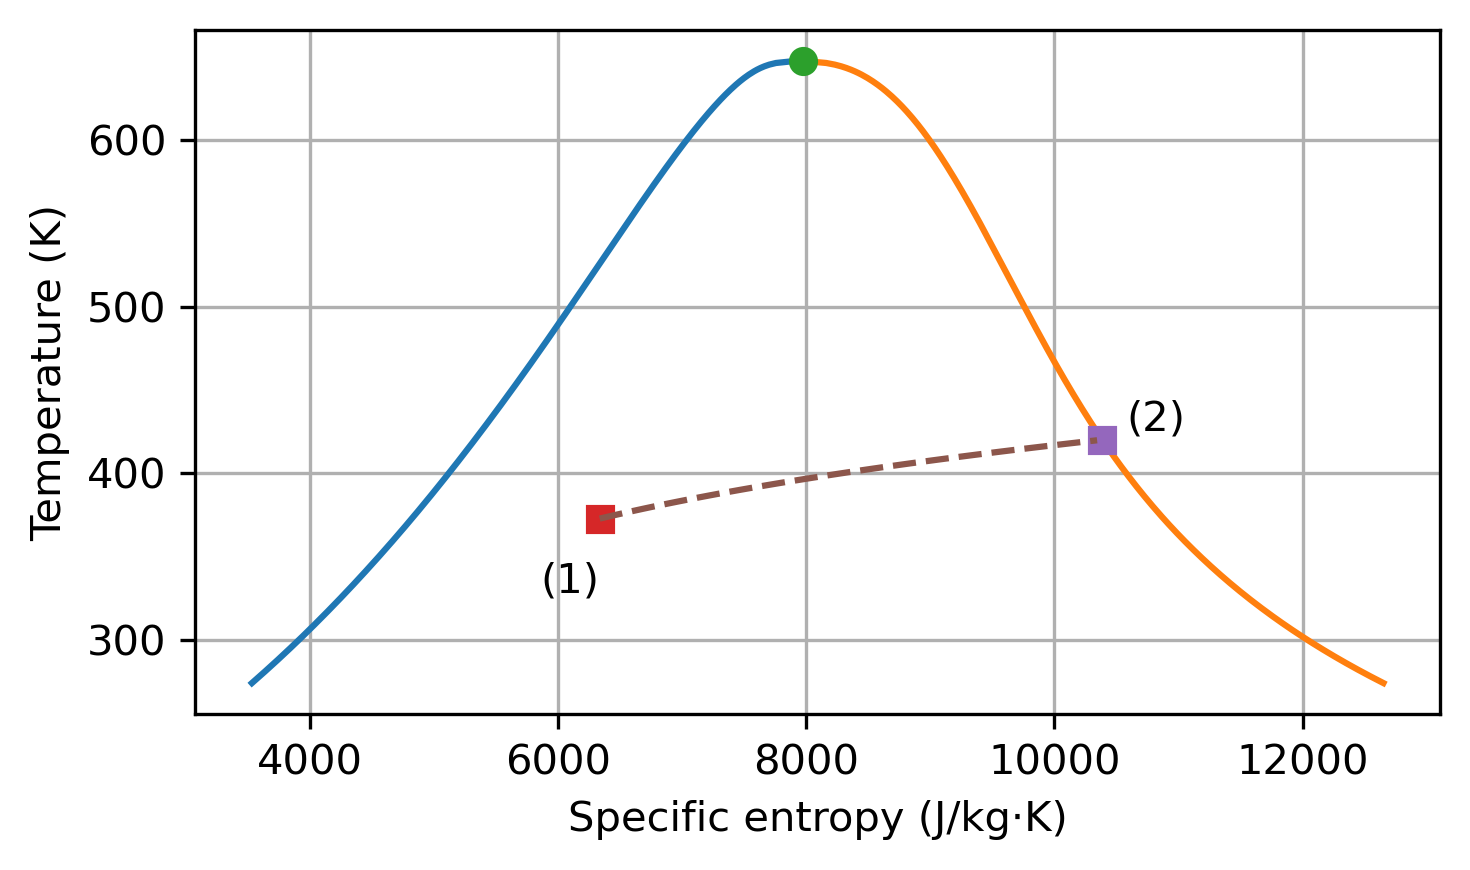

In [7]:
f = ct.Water()

# Array of temperatures from fluid minimum temperature to critical temperature
temps = np.arange(np.ceil(f.min_temp) + 0.15, f.critical_temperature, 1.0)

def get_sat_entropy_fluid(T):
    '''Gets entropy for temperature along saturated liquid line'''
    f = ct.Water()
    f.TQ = T, 0.0
    return f.s
def get_sat_entropy_gas(T):
    '''Gets entropy for temperature along saturated vapor line'''
    f = ct.Water()
    f.TQ = T, 1.0
    return f.s

# calculate entropy values associated with temperatures along
# saturation lines
entropies_f = np.array([get_sat_entropy_fluid(T) for T in temps])
entropies_g = np.array([get_sat_entropy_gas(T) for T in temps])

# critical point
f.TP = f.critical_temperature, f.critical_pressure

fig, ax = plt.subplots(figsize=(5, 3))

# Plot the saturated liquid line, critical point,
# and saturated vapor line
ax.plot(entropies_f, temps)
ax.plot(entropies_g, temps)
ax.plot(f.s, f.T, 'o')
plt.xlabel('Specific entropy (J/kg⋅K)')
plt.ylabel('Temperature (K)')

# Plot the initial and final states, and label them
ax.plot(state_initial.s, state_initial.T, 's')
ax.annotate('(1)', xy=(state_initial.s, state_initial.T),
            xytext=(0, -20), textcoords='offset points',
            ha='right', va='bottom'
            )

ax.plot(state_final.s, state_final.T, 's')
ax.annotate('(2)', xy=(state_final.s, state_final.T),
            xytext=(20, 0), textcoords='offset points',
            ha='right', va='bottom'
            )

# show process line of constant density
temps = np.arange(state_initial.T, state_final.T, 1.0)
def get_entrophy(T, density):
    f = ct.Water()
    f.TD = T, density
    return f.s
entropies = np.array([get_entrophy(T, state_initial.density) for T in temps])
ax.plot(entropies, temps, '--')

plt.grid(True)
fig.tight_layout()
plt.show()